# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 2: Webscraping with BeautifulSoup, Continued

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Nathaniel Burbank, Albert Wu, Matthew Holman <br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from CS109 repo or here: <br> http://bit.ly/109_s2 **</center>


During the first section we worked with tables of historic population estimates of the different US states, as listed on the Wikipedia site: https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population.  We learned how to download a webpage via its URL, to parse the resulting html into a python object with BeautifulSoup, to extract the necessary tables, to convert the results into a pandas dataframe, and finally to make a few plots.

In this section, we will extend those results to include the median household income and other information per state. 
Specifically, we will: 
    
    1. Review the process of downloading a webpage with the requests library 
    2. Revisit how to parse the html into a python object using the BeautifulSoup library
    3. Again use BeautifulSoup to select and extract the relevant tables
    4. Clean the text and convert the table into a python dictionary 
    5. Save and restore the results in files with JSON and csv (pandas)
    6. Make a pandas dataframe from the dictionary
    7. Join the new dataframe with the one we made last week.
    8. Inner vs outer joins 
    9. Do more analysis and plotting (with matplotlib) 

As usual, our first step is to import the necessary libraries.

In [1]:
%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import requests 
requests.packages.urllib3.disable_warnings()
#Requests enables us to download raw html as text
from bs4 import BeautifulSoup 
# BeautifulSoup enables us to navigate html in python with dom-like tree structure 

# Two new ones
import time
# So that we can sleep between downloads
import json
# We'll write and read JSON files later

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

## Download, extract, and parse the relevant webpage as raw html

Next, let's quickly reconstruct the pandas dataframe we made in the last section.  Recall that we

    1. used the requests module to download the page corresponding to a given URL,
    2. extracted the raw HTML of the result, and
    3. used BeautifulSoup to parse the raw HTML.
    
We could repeat each of these steps, but you might have noticed that we only used the final result and ignored the intermediate results.  This calls out for a function definition.


In [2]:
# Dictionary to store already downloaded BeautifulSoup objects 
html_cache = dict()

In [3]:
def dl_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """Downloads the content of the page specified by url.
    Return the parsed HTML or None upon error.
    Notice that timeout, verify, and sleep_time have 
    defaults values"""
    
    # Down load the context at url
    r = requests.get(url, timeout=20,verify=False)
    
    # Check if HTTP status code is anything other than "ok"
    if r.status_code != 200:
        return None
    
    # Grab the raw HTML of the result
    raw_html = r.text
    
    # Parse the raw HTML with Beautiful soup
    soup = BeautifulSoup(raw_html, 'html.parser')
    
    # We have added a default 1 sec sleep
    time.sleep(sleep_time)
    
    # Return the parsed results
    return soup

def get_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """If we’ve already downloaded a webpage, return from cache. 
    Otherwise, download and parse using dl_parsed_html above."""
    if url not in html_cache:
        parsed_html = dl_parsed_html(url, timeout, verify, sleep_time)
        if parsed_html:
            html_cache[url] = parsed_html 
            
    return html_cache.get(url,None)

Now let's use our new function to download and parse the US historical population information again.

In [4]:
soup = get_parsed_html("http://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population")
soup.find('title').text

'List of U.S. states by historical population - Wikipedia'

We can use find_all to get the tables of interest again.

In [5]:
tables = soup.find_all("table",attrs={"class":"wikitable"})
# This says return a list of all table objects that include 
# the css class “wikitable” within the soup object.  

# We only need the first, third, and fourth tables.
tables = [tables[0], tables[2], tables[3]]

We can render the first table, to inspect it, as we did in the previous section.

In [6]:
from IPython.core.display import display, HTML
display(HTML(tables[0].prettify()))

Name,Admitted,1790,1800,1810,1820,1830,1840,1850,1860
Alabama,1819,,"1,250","9,046","127,901","309,527","590,756","771,623","964,201"
Alaska,1959,,,,,,,,
Arizona,1912,,,,,,,,
Arkansas,1836,,,"1,062","14,273","30,388","97,574","209,897","435,450"
California,1850,,,,,,,"92,597","379,994"
Colorado,1876,,,,,,,,"34,277"
Connecticut,1788,"237,946","251,002","262,042","275,202","297,675","309,978","370,792","460,147"
Delaware,1787,"59,096","64,273","72,674","72,749","76,748","78,085","91,532","112,216"
District of Columbia [1],,,"8,144","15,471","23,336","30,261","33,745","51,687","75,080"
Florida,1845,,,,,"34,730","54,477","87,445","140,424"


## Clean data and build dictionary

Here is the code we used in the previous section to clean the data and build the dictionary, row by row, from a list of tables.

In [7]:
def rm_footnotes(s):
    """Removes any text after first '[' in string
    District of Columbia[1] -> District of Columbia"""
    return s.split('[')[0]

def clean_int(s):
    """Removes any commas, '$' symbols, or footnotes from string and converts to int.
    Returns zero for blank strings"""
    s = s.strip().replace(',','').replace('$', '')
    s = rm_footnotes(s)
    return int(s) if s else 0

In [8]:
d = dict()

for table in tables:
    """Extracts population data for states from all tables in tables 
      and store it in single dictionary d """
    
    headrow = table.find("tr")
    
    col_names = [(idx,th.text) for idx,th in enumerate(headrow.find_all('th')) if th.text.isnumeric()]
    # Makes list of tuples like this with idx and name for cols with years.
    # By using isnumeric, we only include columns are that are years. 
    # Result looks like this: 
    # [(2, '1790'), (3, '1800'), (4, '1810')]                     
    
    rows = table.find_all("tr")[1:]
    # List of rows in table excluding the header row 
    
    for row in rows:
        state_name = rm_footnotes(row.find('td').text)
        # String of state name, with any footnotes removed 
        
        all_cells = [c.text for c in row.find_all('td')]
        # List of cell values for row, e.g.: 
        # ['Alabama', '1819', '\xa0', '1,250', '9,046' .. ] 
        
        existing_values = d.get(state_name,{})
        # Existing dict of values for given state 
        
        new_values = {year:clean_int(all_cells[idx]) for (idx,year) in col_names}
        # For cols listed in col_names, return dict of cleaned int values 
        # {'1790': 0, '1800': 1250, '1810': 9046...}
        
        existing_values.update(new_values)
        # Merge with existing dict for state 
        d[state_name] = existing_values


## Use JSON to save and restore data

JSON (JavaScript Object Notation) is a simple data exchange format that can be used to serialize many data objects. To serialize an object means to convert it to a format that can be transmitted in a series, either to or from files or across a network.  This is particularly easy in python.  (See [pickle](https://docs.python.org/3/library/pickle.html) for an alternative means of 'serializing' python objects that supports a larger range of python objects but is not human readable (and not a universal format like json)

Here we'll use JSON to save our dictionary so that we can just load it from the file, if we need in the future.

In [11]:
filename = "historical_population.json"

# Open a file descriptor for writing, with the filename 'historical_population.json'.
# Convert our dictionary 'd' to JSON and output it to the file.
# Close the file.

# Your code here 
with open(filename, 'w') as fd:
    json.dump(d, fd, indent=4)

A convenient feature of JSON is that the resulting files are ASCII and thus simple to read (although they are larger than a corresponding binary format would be).

Let's use a shell command to look at the actual file.

In [12]:
!cat historical_population.json
# exclamation point here is a "magic" command that means 
# run line as shell command in terminal

{
    "United States": {
        "1830": 12860702,
        "1950": 150697361,
        "1910": 91972266,
        "2000": 281421906,
        "1820": 9638453,
        "1790": 3929214,
        "1930": 122775046,
        "2010": 308745538,
        "1900": 75994575,
        "1880": 50155783,
        "1940": 131669275,
        "1860": 31443321,
        "1810": 7239881,
        "1800": 5308483,
        "1990": 248709873,
        "1960": 179323175,
        "1980": 226545805,
        "1890": 62947714,
        "1970": 203211926,
        "1850": 23191876,
        "1920": 105710620,
        "1870": 38558371,
        "1840": 17063353
    },
    "Connecticut": {
        "1830": 297675,
        "1950": 2007280,
        "1910": 1114756,
        "2000": 3405565,
        "1820": 275202,
        "1790": 237946,
        "1930": 1606903,
        "2010": 3574097,
        "1900": 908420,
        "1880": 622700,
        "1940": 1709242,
        "1860": 460147,
        "1810": 262042,
        "1800": 251002,
  

It looks a lot like a python dictionary!

Let's demonstrate the use of JSON files by deleting d and then reloading it.

In [13]:
del d

In [14]:
d

NameError: name 'd' is not defined

In [16]:
# Now open the json file back up and save the results to d

# your code here
with open(filename, 'r') as fd:
    d = json.load(fd)

In [17]:
d

{'Alabama': {'1790': 0,
  '1800': 1250,
  '1810': 9046,
  '1820': 127901,
  '1830': 309527,
  '1840': 590756,
  '1850': 771623,
  '1860': 964201,
  '1870': 996992,
  '1880': 1262505,
  '1890': 1513017,
  '1900': 1828697,
  '1910': 2138093,
  '1920': 2348174,
  '1930': 2646248,
  '1940': 2832961,
  '1950': 3061743,
  '1960': 3266740,
  '1970': 3444165,
  '1980': 3893888,
  '1990': 4040587,
  '2000': 4447100,
  '2010': 4779736},
 'Alaska': {'1790': 0,
  '1800': 0,
  '1810': 0,
  '1820': 0,
  '1830': 0,
  '1840': 0,
  '1850': 0,
  '1860': 0,
  '1870': 0,
  '1880': 0,
  '1890': 33426,
  '1900': 32052,
  '1910': 64356,
  '1920': 55036,
  '1930': 59278,
  '1940': 72524,
  '1950': 128643,
  '1960': 226167,
  '1970': 300382,
  '1980': 401851,
  '1990': 550043,
  '2000': 626932,
  '2010': 710231},
 'Arizona': {'1790': 0,
  '1800': 0,
  '1810': 0,
  '1820': 0,
  '1830': 0,
  '1840': 0,
  '1850': 0,
  '1860': 0,
  '1870': 9658,
  '1880': 40440,
  '1890': 88243,
  '1900': 122931,
  '1910': 204354,

We successfully restored the dictionary from its JSON file!

## Generate the dataframe

Now that we have the dictionary, it's straightfoward to generate a pandas dataframe from it.

In [18]:
# Generate the dataframe from the dictionary.
df = pd.DataFrame.from_dict(d,orient='index')

# Drop unneeded rows.
df = df.drop(["United States"])  

# Sort the columns in increasing (alphabetical) order.
df = df.reindex_axis(sorted(df.columns), axis=1)

df.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1513017,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736
Alaska,0,0,0,0,0,0,0,0,0,0,33426,32052,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231
Arizona,0,0,0,0,0,0,0,0,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918
California,0,0,0,0,0,0,92597,379994,560247,864694,1213398,1485053,2377549,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956


## Alternative to saving JSON – save dataframe object as csv 

In [19]:
df.to_csv("historical_population.csv")

In [20]:
!cat historical_population.csv

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1513017,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736
Alaska,0,0,0,0,0,0,0,0,0,0,33426,32052,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231
Arizona,0,0,0,0,0,0,0,0,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918
California,0,0,0,0,0,0,92597,379994,560247,864694,1213398,1485053,2377549,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956
Colorado,0,0,0,0,0,0,0,34277,39864,194327,413249,539700,799024,939629,1035791,1123296,1325089,1753947,2207259,2889964,3294394,4301261,5029

In [21]:
df.from_csv("historical_population.csv").head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1513017,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736
Alaska,0,0,0,0,0,0,0,0,0,0,33426,32052,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231
Arizona,0,0,0,0,0,0,0,0,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918
California,0,0,0,0,0,0,92597,379994,560247,864694,1213398,1485053,2377549,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956


Exporting as csv is another useful method for saving a data frame offline you can easily jump back to your dataset without needed to re-scrape from Wikipedia. Note however that when we export as csv, no metadata about the data frame is saved which can cause subtle differences on re-import in the datatypes of your columns and which column is used as the index.  

## Download, extract, and parse another webpage

Now that we have regenerated the dictionary and dataframe from last section, let's demonstrate a slightly different approach to downloading, extracting, and parsing.   This time we will look at a webpage of the US states by income.

We'll re-use our previous function to download and parse the page.

In [22]:
soup = get_parsed_html("https://en.wikipedia.org/wiki/List_of_U.S._states_by_income")
soup.find('title').text

'List of U.S. states by income - Wikipedia'

In [23]:
tables = soup.find_all("table",attrs={"class":"wikitable"})
# This says return a list of all table objects that include 
# the css class “wikitable” within the soup object.  
len(tables)

2

This page has two wikitables, and we are interested in the second one, which looks like this.

In [24]:
# Let's render the second table as HTML
from IPython.core.display import display, HTML
display(HTML(tables[1].prettify()))

Rank,State,Per capita income,Median household income,Median family income,Population,Number of households,Number of families
,District of Columbia,"$45,877","$71,648","$84,094","658,893","277,378","117,864"
1,Connecticut,"$39,373","$70,048","$88,819","3,596,677","1,355,817","887,263"
2,New Jersey,"$37,288","$69,160","$87,951","8,938,175","2,549,336","1,610,581"
3,Massachusetts,"$36,593","$71,919","$88,419","6,938,608","3,194,844","2,203,675"
4,Maryland,"$36,338","$73,971","$89,678","5,976,407","2,165,438","1,445,972"
5,New Hampshire,"$34,691","$66,532","$80,581","1,326,813","519,756","345,901"
6,Virginia,"$34,052","$64,902","$78,290","8,326,289","3,083,820","2,058,820"
7,New York,"$33,095","$58,878","$71,115","19,746,227","7,282,398","4,621,954"
8,North Dakota,"$33,071","$59,029","$75,221","739,482","305,431","187,800"
9,Alaska,"$33,062","$71,583","$82,307","736,732","249,659","165,015"


## Convert the html table directly into a pandas dataframe

For well formatted HTML tables the pandas read_html method works like a charm, and it can be much easier than building a dataframe row by row. 

With the read_html method, we can specify which row has the column names and which column is the index.  We'll start by using the first row and first column.

In [25]:
df1 = pd.read_html(tables[1].prettify(),header=0, index_col=0)[0]

In [26]:
df1.head()

,State,Per capita income,Median household income,Median family income,Population,Number of households,Number of families
Rank,,,,,,,
NaN,District of Columbia,"$45,877","$71,648","$84,094",658893,277378,117864
1.0,Connecticut,"$39,373","$70,048","$88,819",3596677,1355817,887263
2.0,New Jersey,"$37,288","$69,160","$87,951",8938175,2549336,1610581
3.0,Massachusetts,"$36,593","$71,919","$88,419",6938608,3194844,2203675
4.0,Maryland,"$36,338","$73,971","$89,678",5976407,2165438,1445972


## Clean up the dataframe

There are a few things we should clean up before proceeding. First let's set the index to be the'State' column.  

In [27]:
df1 = df1.set_index('State')

Note that by overwriting the index, we’re discarding the 'Rank' column.

In [28]:
df1.head()

,Per capita income,Median household income,Median family income,Population,Number of households,Number of families
State,,,,,,
District of Columbia,"$45,877","$71,648","$84,094",658893,277378,117864
Connecticut,"$39,373","$70,048","$88,819",3596677,1355817,887263
New Jersey,"$37,288","$69,160","$87,951",8938175,2549336,1610581
Massachusetts,"$36,593","$71,919","$88,419",6938608,3194844,2203675
Maryland,"$36,338","$73,971","$89,678",5976407,2165438,1445972


Next, let's drop the 'United States' row -- but keep your eye on the District of Columbia and Puerto Rico rows.

In [29]:
df1 = df1.drop(["United States"])

Also, the column names have one or more spaces embedded in them.  That can make the columns difficult to select.  Fortunately, a pandas dataframe allows easy access to the column names as follows:

In [30]:
df1.columns.values

array(['Per capita  income', 'Median  household  income',
       'Median  family  income', 'Population', 'Number of  households',
       'Number of  families'], dtype=object)

Notice that this is a numpy array of type 'object' with a list of column names.
We can write a quick reformatting function and apply it to all the column names.  

Here we use both 'strip' which is a built_in method of string objects and the 're' (regular expression) substitution method.  Regular expressions are a powerful, concise way of representing an enormous range of string transformations.  

To learn more about regular expresions in python, see:
https://docs.python.org/3/library/re.html

In [31]:
import re
def clean_column_name(s):
    """This removes any leading or trailing spaces and
    replaces multiple embedded spaces with a single
    underscore character
    
    'Per capita  income' -> 'Per_capita_income'
    """
    # Your code here
    s = re.sub(' +', '_', s)
    return s

new_column_names = list(map(clean_column_name, list(df1.columns.values)))

# Here's our set of reformatted column names
new_column_names

['Per_capita_income',
 'Median_household_income',
 'Median_family_income',
 'Population',
 'Number_of_households',
 'Number_of_families']

Now we can reset the column names. 

In [32]:
df1.columns = new_column_names
df1.head()

,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families
State,,,,,,
District of Columbia,"$45,877","$71,648","$84,094",658893,277378,117864
Connecticut,"$39,373","$70,048","$88,819",3596677,1355817,887263
New Jersey,"$37,288","$69,160","$87,951",8938175,2549336,1610581
Massachusetts,"$36,593","$71,919","$88,419",6938608,3194844,2203675
Maryland,"$36,338","$73,971","$89,678",5976407,2165438,1445972


That's better!

Let’s say we were interested in identifying states that had a large divergence between Median household income and Median family income. 

Per the Census Bureau’s [definitions](https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html#familyhousehold), a family is “a group of two people or more (one of whom is the householder) related by birth, marriage, or adoption and residing together; all such people (including related subfamily members) are considered as members of one family.” Conversely, a household “consists of all the people who occupy a housing unit.”

In [33]:
df1.Median_family_income - df1.Median_household_income

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Uh oh --- that did not work – what’s wrong?

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, District of Columbia to Puerto Rico
Data columns (total 6 columns):
Per_capita_income          52 non-null object
Median_household_income    52 non-null object
Median_family_income       52 non-null object
Population                 52 non-null int64
Number_of_households       52 non-null int64
Number_of_families         52 non-null int64
dtypes: int64(3), object(3)
memory usage: 2.8+ KB


This does not work becuase these two columens are represented by strings rather than ints or float objects. On import, pandas interpreted them as strings rather than floats or ints because of the '\$' symbols in them. Let's use our clean_int function from last time to solve this issue.  (Notice, that clean_int now replaces '\$' symbols too.)  If we 'apply' clean_int to the Per_capita_income column, we get the following:

In [35]:
df1['Per_capita_income'].apply(clean_int)

State
District of Columbia    45877
Connecticut             39373
New Jersey              37288
Massachusetts           36593
Maryland                36338
New Hampshire           34691
Virginia                34052
New York                33095
North Dakota            33071
Alaska                  33062
Minnesota               32638
Colorado                32357
Washington              31841
Rhode Island            30830
Delaware                30488
California              30441
Illinois                30417
Hawaii                  29736
Wyoming                 29698
Pennsylvania            29220
Vermont                 29178
Iowa                    28361
Wisconsin               28213
Maine                   27978
Kansas                  27870
Oregon                  27646
Nebraska                27446
Texas                   27125
South Dakota            26959
Ohio                    26937
Michigan                26613
Florida                 26582
Missouri                26126
Mont

Since we have three such columns to deal with, let's clean them in bulk.

In [36]:
for colname in ['Per_capita_income', 'Median_household_income', 'Median_family_income']:
    df1[colname] = df1[colname].apply(clean_int)

In [37]:
df1.head()

,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families
State,,,,,,
District of Columbia,45877,71648,84094,658893,277378,117864
Connecticut,39373,70048,88819,3596677,1355817,887263
New Jersey,37288,69160,87951,8938175,2549336,1610581
Massachusetts,36593,71919,88419,6938608,3194844,2203675
Maryland,36338,73971,89678,5976407,2165438,1445972


Why does this work?  Aren't we changing the columns as we go?

Now let’s get back to looking at the difference between median household and family by state.

In [38]:
df1['Household_family_diff'] = df1.Median_family_income - df1.Median_household_income
df1.head()

,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families,Household_family_diff
State,,,,,,,
District of Columbia,45877,71648,84094,658893,277378,117864,12446
Connecticut,39373,70048,88819,3596677,1355817,887263,18771
New Jersey,37288,69160,87951,8938175,2549336,1610581,18791
Massachusetts,36593,71919,88419,6938608,3194844,2203675,16500
Maryland,36338,73971,89678,5976407,2165438,1445972,15707


Let’s identify the states with the largest differential... 

In [39]:
key_cols = ['Median_family_income','Median_household_income','Household_family_diff']
df1.sort_values(['Household_family_diff'],ascending=False)[key_cols].head(5)

,Median_family_income,Median_household_income,Household_family_diff
State,,,
New Jersey,87951,69160,18791
Connecticut,88819,70048,18771
Massachusetts,88419,71919,16500
Minnesota,77941,61481,16460
Rhode Island,71212,54891,16321


And the smallest... 

In [40]:
df1.sort_values(['Household_family_diff'])[key_cols].head(5)

,Median_family_income,Median_household_income,Household_family_diff
State,,,
Puerto Rico,22477,18928,3549
Utah,69535,60922,8613
California,71015,61933,9082
Nevada,60824,51450,9374
Georgia,58885,49321,9564


## Plot our data!

<function matplotlib.pyplot.rc>

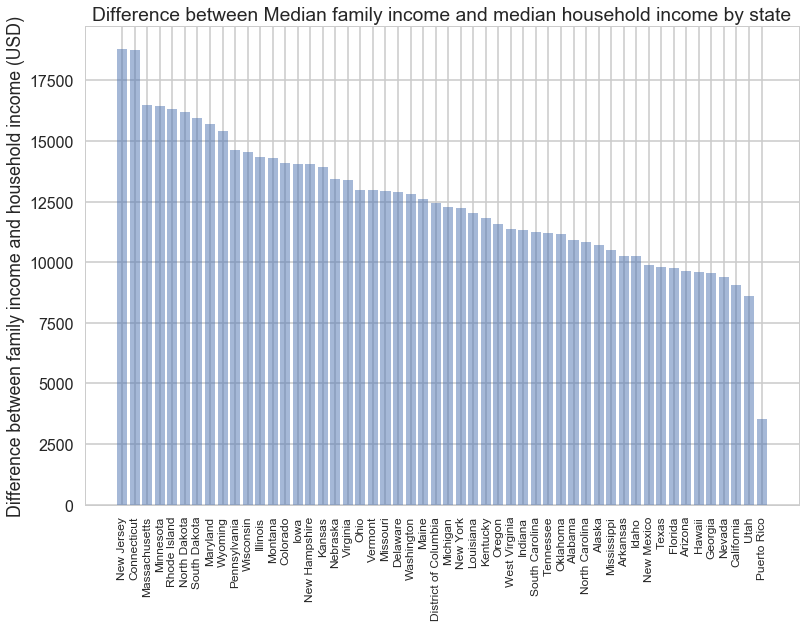

In [41]:
y_values = (df1['Household_family_diff']).sort_values(ascending=False)
x_values = list(y_values.index)
x_pos = np.arange(len(y_values))

plt.bar(x_pos,y_values, align='center', alpha=0.5)
plt.xticks(x_pos, x_values, rotation=90, fontsize=12)
plt.ylabel('Difference between family income and household income (USD)')
plt.title('Difference between Median family income and median household income by state')

new_style = {'grid': False}
plt.rc('axes', **new_style)
plt.rc

We can make almost the exact same chart using Panda’s  built in “plot” command with much less code.

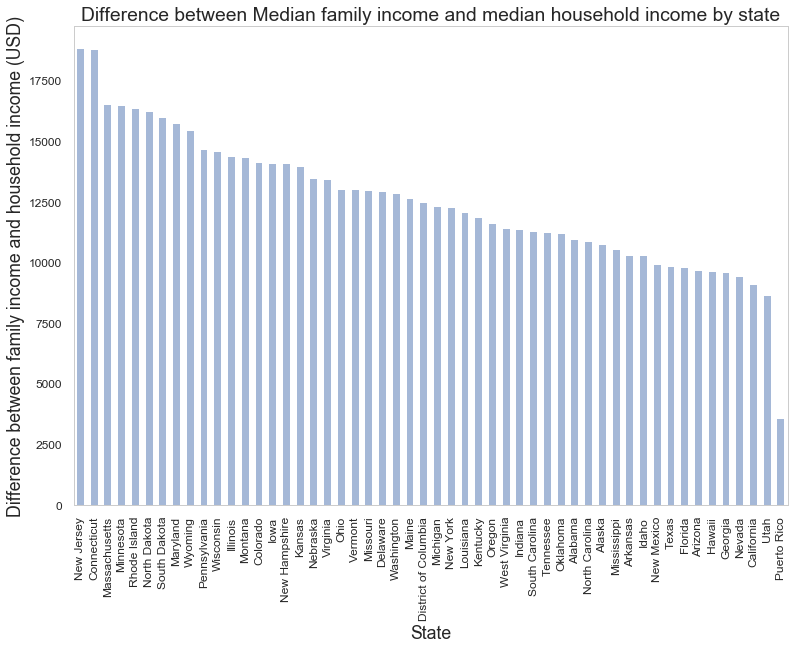

In [42]:
df1['Household_family_diff'].sort_values(ascending=False).plot(kind="bar", alpha=.5, fontsize=12)
plt.ylabel('Difference between family income and household income (USD)')
plt.title('Difference between Median family income and median household income by state')

## Combine dataframes

What if we want to combine out two dataframes?   There are a number of ways to do this.  

One way is to use the Pandas concat function.  It stitches the two data frames together based on their **index values**.  

In [43]:
result = pd.concat([df, df1], axis=1, join='inner')
print(len(result))
result.head()

50


,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families,Household_family_diff
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1513017,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736,23606,42830,53764,4849377,1841217,1232515,10934
Alaska,0,0,0,0,0,0,0,0,0,0,33426,32052,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231,33062,71583,82307,736732,249659,165015,10724
Arizona,0,0,0,0,0,0,0,0,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017,25715,50068,59700,6731484,2428743,1579481,9632
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918,22883,41262,51528,2966369,1131288,752212,10266
California,0,0,0,0,0,0,92597,379994,560247,864694,1213398,1485053,2377549,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956,30441,61933,71015,38802500,12758648,8762059,9082


Let's check the results by comparing the 'Connecticut' from each of the constituent dataframes.

In [44]:
df.loc['Connecticut']

1790     237946
1800     251002
1810     262042
1820     275202
1830     297675
1840     309978
1850     370792
1860     460147
1870     537454
1880     622700
1890     746258
1900     908420
1910    1114756
1920    1380631
1930    1606903
1940    1709242
1950    2007280
1960    2535234
1970    3031709
1980    3107576
1990    3287116
2000    3405565
2010    3574097
Name: Connecticut, dtype: int64

In [45]:
df1.loc['Connecticut']

Per_capita_income            39373
Median_household_income      70048
Median_family_income         88819
Population                 3596677
Number_of_households       1355817
Number_of_families          887263
Household_family_diff        18771
Name: Connecticut, dtype: int64

Notice that we can also do an 'outer' join.  What's the difference?

In [46]:
result = pd.concat([df, df1], axis=1, join='outer')
print(len(result))
result

53


,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families,Household_family_diff
Alabama,0.0,1250.0,9046.0,127901.0,309527.0,590756.0,771623.0,964201.0,996992.0,1262505.0,1513017.0,1828697.0,2138093.0,2348174.0,2646248.0,2832961.0,3061743.0,3266740.0,3444165.0,3893888.0,4040587.0,4447100.0,4779736.0,23606.0,42830.0,53764.0,4849377.0,1841217.0,1232515.0,10934.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33426.0,32052.0,64356.0,55036.0,59278.0,72524.0,128643.0,226167.0,300382.0,401851.0,550043.0,626932.0,710231.0,33062.0,71583.0,82307.0,736732.0,249659.0,165015.0,10724.0
Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9658.0,40440.0,88243.0,122931.0,204354.0,334162.0,435573.0,499261.0,749587.0,1302161.0,1770900.0,2718215.0,3665228.0,5130632.0,6392017.0,25715.0,50068.0,59700.0,6731484.0,2428743.0,1579481.0,9632.0
Arkansas,0.0,0.0,1062.0,14273.0,30388.0,97574.0,209897.0,435450.0,484471.0,802525.0,1128211.0,1311564.0,1574449.0,1752204.0,1854482.0,1949387.0,1909511.0,1786272.0,1923295.0,2286435.0,2350725.0,2673400.0,2915918.0,22883.0,41262.0,51528.0,2966369.0,1131288.0,752212.0,10266.0
California,0.0,0.0,0.0,0.0,0.0,0.0,92597.0,379994.0,560247.0,864694.0,1213398.0,1485053.0,2377549.0,3426861.0,5677251.0,6907387.0,10586223.0,15717204.0,19953134.0,23667902.0,29760021.0,33871648.0,37253956.0,30441.0,61933.0,71015.0,38802500.0,12758648.0,8762059.0,9082.0
Colorado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34277.0,39864.0,194327.0,413249.0,539700.0,799024.0,939629.0,1035791.0,1123296.0,1325089.0,1753947.0,2207259.0,2889964.0,3294394.0,4301261.0,5029196.0,32357.0,61303.0,75405.0,5355866.0,2039592.0,1315283.0,14102.0
Connecticut,237946.0,251002.0,262042.0,275202.0,297675.0,309978.0,370792.0,460147.0,537454.0,622700.0,746258.0,908420.0,1114756.0,1380631.0,1606903.0,1709242.0,2007280.0,2535234.0,3031709.0,3107576.0,3287116.0,3405565.0,3574097.0,39373.0,70048.0,88819.0,3596677.0,1355817.0,887263.0,18771.0
Delaware,59096.0,64273.0,72674.0,72749.0,76748.0,78085.0,91532.0,112216.0,125015.0,146608.0,168493.0,184735.0,202322.0,223003.0,238380.0,266505.0,318085.0,446292.0,548104.0,594338.0,666168.0,783600.0,897934.0,30488.0,59716.0,72594.0,935614.0,349743.0,233000.0,12878.0
District of Columbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45877.0,71648.0,84094.0,658893.0,277378.0,117864.0,12446.0
District of Columbia,0.0,8144.0,15471.0,23336.0,30261.0,33745.0,51687.0,75080.0,131700.0,177624.0,230392.0,278718.0,331069.0,437571.0,486869.0,663091.0,802178.0,763956.0,756510.0,638333.0,606900.0,572059.0,601723.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that “District of Columbia” is listed twice above. What’s going on? Why didn’t it match?

In [47]:
df.index[8]

'District\xa0of\xa0Columbia'

In [48]:
df1.index[0]

'District of Columbia'

In [49]:
df.index[8] == df1.index[0]

False

Note even though the strings *look* the same, slight differences in the way the strings are encoded keep pandas from matching them up. If we wanted to fix this, we’d probably want to go back to the import stage and do it there. Adjusting indexes once they’ve been assigned is messy in pandas. 

In [50]:
result = pd.concat([df, df1], axis=1, join='inner')

Another approach is to use the merge method on the shared values in two specified columns.  Let's explore this by copying the index column to a column of a slightly different name.  (If we had available some other shared key, we could use that.)

In [51]:
df['state'] = df.index
df1['state'] = df1.index

In [52]:
combined_df= df1.merge(df, on='state', how='inner')
len(combined_df)

50

In [53]:
combined_df.head()

,Per_capita_income,Median_household_income,Median_family_income,Population,Number_of_households,Number_of_families,Household_family_diff,state,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
0,39373,70048,88819,3596677,1355817,887263,18771,Connecticut,237946,251002,262042,275202,297675,309978,370792,460147,537454,622700,746258,908420,1114756,1380631,1606903,1709242,2007280,2535234,3031709,3107576,3287116,3405565,3574097
1,37288,69160,87951,8938175,2549336,1610581,18791,New Jersey,184139,211149,245555,277575,320823,373306,489555,672035,906096,1131116,1444933,1883669,2537167,3155900,4041334,4160165,4835329,6066782,7168164,7364823,7730188,8414350,8791894
2,36593,71919,88419,6938608,3194844,2203675,16500,Massachusetts,378787,422845,472040,523287,610408,737699,994514,1231066,1457351,1783085,2238943,2805346,3366416,3852356,4249614,4316721,4690514,5148578,5689170,5737037,6016425,6349097,6547629
3,36338,73971,89678,5976407,2165438,1445972,15707,Maryland,319728,341548,380546,407350,447040,470019,583034,687049,780894,934943,1042390,1188044,1295346,1449661,1631526,1821244,2343001,3100689,3922399,4216975,4781468,5296486,5773552
4,34691,66532,80581,1326813,519756,345901,14049,New Hampshire,141885,183858,214360,244161,269328,284574,317976,326073,318300,346991,376530,411588,430572,443083,465293,491524,533242,606921,737681,920610,1109252,1235786,1316470


Note here that the while the resulting table is correct, we’ve abounded our index which makes the table harder to work with. 

## Analysis on joined frame – what drives household income? 

Finally, let’s explore a couple of possible drivers of median household income.

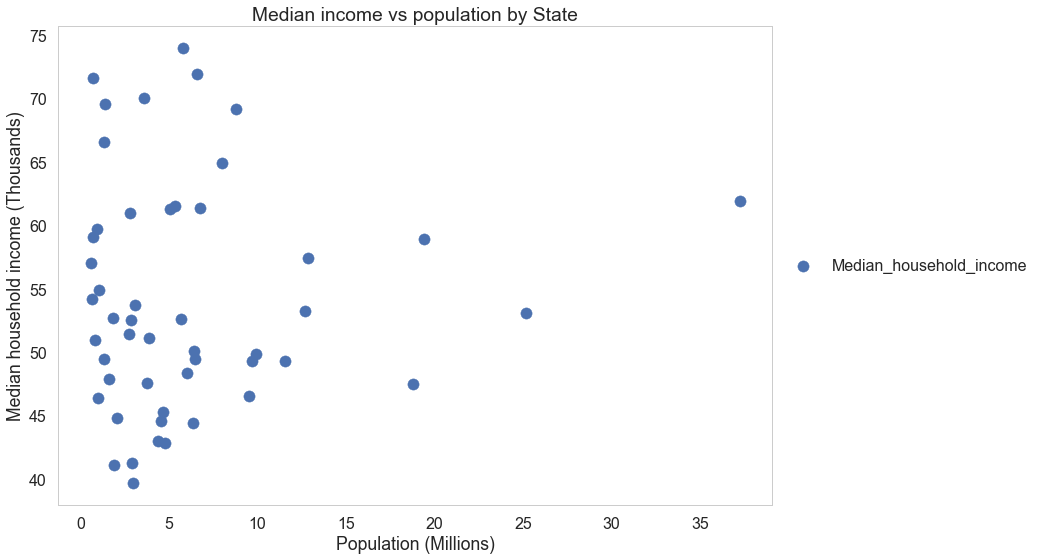

In [54]:
plt.scatter(combined_df['2010']/1e6, combined_df['Median_household_income']/1e3)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Median income vs population by State")
plt.xlabel("Population (Millions)")
plt.ylabel("Median household income (Thousands)")

Perhaps we think population *growth*, rather than raw size is what matters…

In [55]:
population_growth = result['2010']/result['1980']
population_growth

Alabama           1.227497
Alaska            1.767399
Arizona           2.351549
Arkansas          1.275312
California        1.574029
Colorado          1.740228
Connecticut       1.150124
Delaware          1.510814
Florida           1.929067
Georgia           1.773287
Hawaii            1.410090
Idaho             1.660689
Illinois          1.122882
Indiana           1.180972
Iowa              1.045489
Kansas            1.207067
Kentucky          1.185368
Louisiana         1.077860
Maine             1.181122
Maryland          1.369122
Massachusetts     1.141291
Michigan          1.067108
Minnesota         1.301267
Mississippi       1.177201
Missouri          1.218082
Montana           1.257694
Nebraska          1.163404
Nevada            3.373610
New Hampshire     1.429998
New Jersey        1.193769
New Mexico        1.580465
New York          1.103658
North Carolina    1.621194
North Dakota      1.030448
Ohio              1.068429
Oklahoma          1.239997
Oregon            1.454964
P

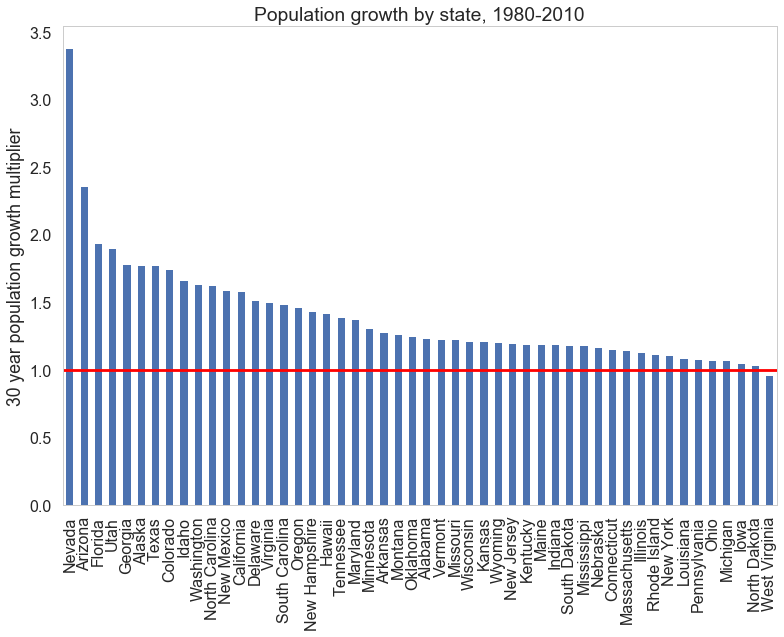

In [56]:
plt.title("Population growth by state, 1980-2010")
population_growth.sort_values(ascending=False).plot(kind='bar')
plt.axhline(y=1, color='r', linestyle='-')
# Draw a dotted line at y=1
plt.ylabel("30 year population growth multiplier")

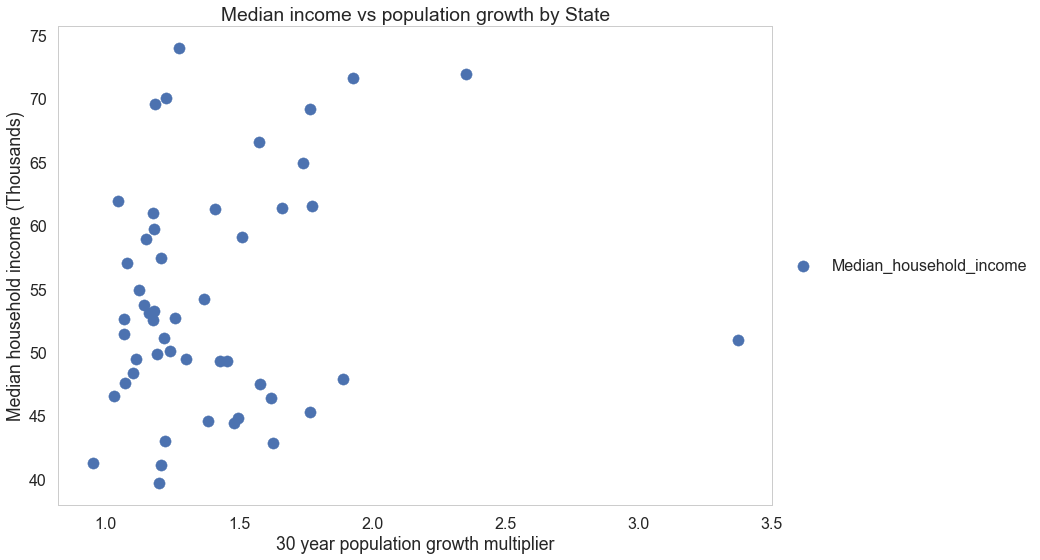

In [57]:
plt.scatter(population_growth, combined_df.Median_household_income/1e3)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Median income vs population growth by State")
plt.xlabel("30 year population growth multiplier")
plt.ylabel("Median household income (Thousands)")